In [1]:
import sys
from pathlib import Path

# Add parent directory to path so we can import utils_pdhg
sys.path.insert(0, str(Path('.').resolve().parent))

import torch
import json 
from omegaconf import DictConfig, OmegaConf 
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 

from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_fista_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/attn_fista_adamw/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_fista_adamw and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, rho_over_lr=1.0, attn_max_iter=100, warm_start=False, lsqr_max_iter=1000momentum=False, diag_scaling=False, pd_type='fista', reflected_halpern=False, enable_restart=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 5.7237982749938965
In rank: 0, time taken for epoch 1 :  77.7662959

In [3]:
with initialize(config_path="../../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/attn_fista_adamw/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/attn_fista_adamw/bs-4-lr-0.001-wd-0/attn_fista_adamw-lr-0.001-constant-linear-e770b7297b77ef9cf3405e5b305e552f.json


iteration=0
  layer    A1_norm    A2_norm   G2_norm   G1_norm    Y_norm
0     0  15.402474  15.411361  0.013209  0.013600  0.007832
1     1  15.394176  15.394062  0.003659  0.003802  0.002222
2     2  15.383726  15.393147  0.001973  0.002151  0.001095
3     3  15.394167  15.398066  0.001705  0.001678  0.000887


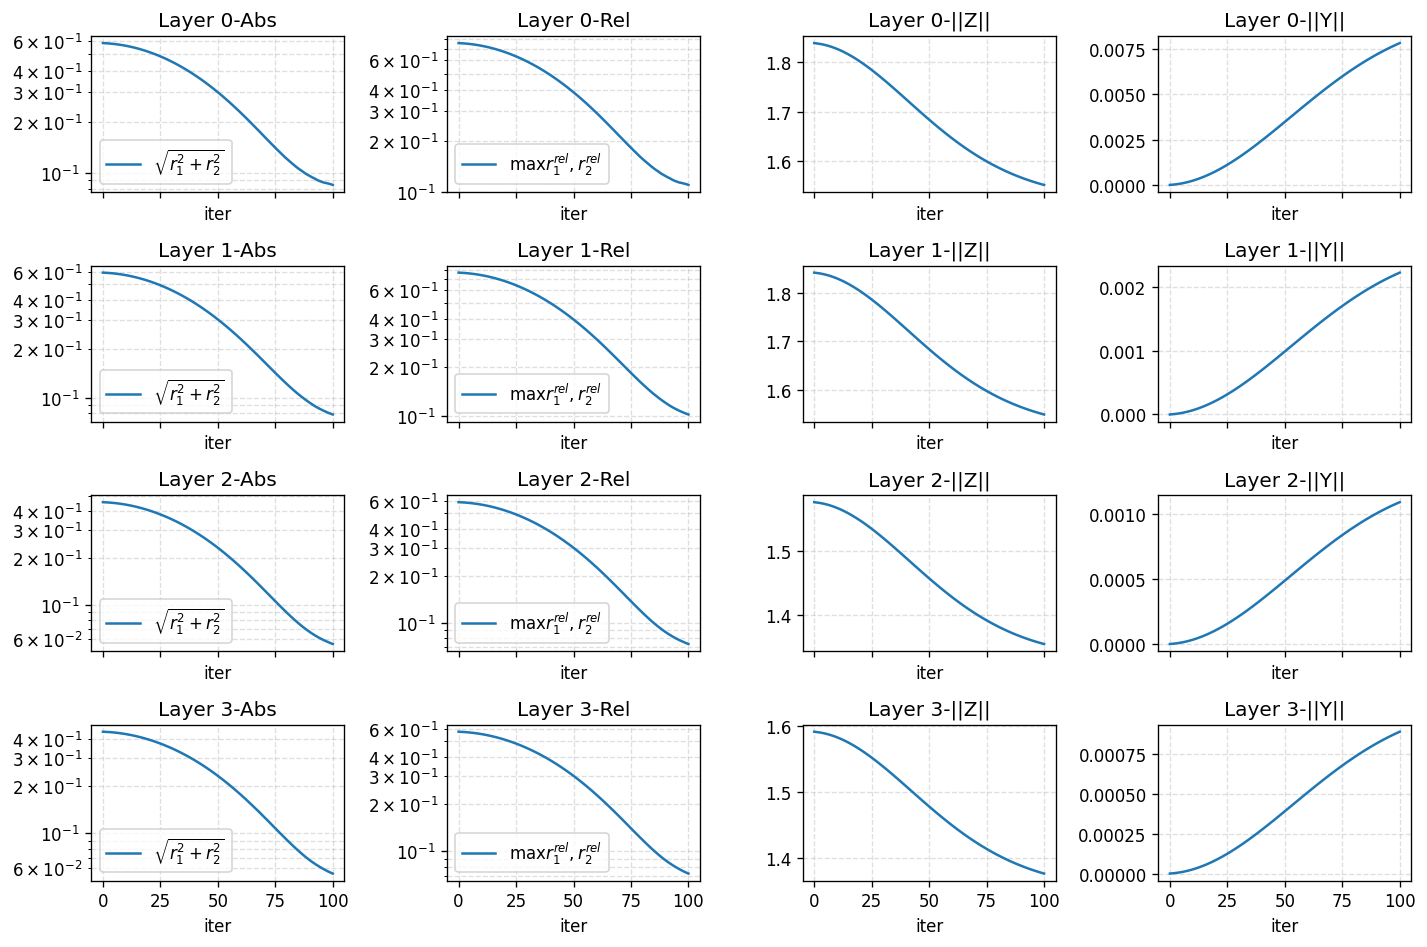

In [4]:
it = 0
print(f"iteration={it}")
import pandas as pd
it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)

plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

In [5]:
layer_res.keys()

dict_keys(['r1', 'r2', 'r1_rel', 'r2_rel', 'z_norm', 'y_norm', 'r_rel', 'dual_vals', 'A1_norm', 'A2_norm', 'G1_norm', 'G2_norm', 'Y_norm'])

iteration=50
  layer    A1_norm    A2_norm   G2_norm   G1_norm    Y_norm
0     0  16.539066  15.667441  0.122433  0.052883  0.031407
1     1  13.288042  13.205911  0.006243  0.006046  0.001082
2     2   9.709758  10.002581  0.005097  0.005991  0.000986
3     3   9.125244   9.380564  0.015433  0.019632  0.002498


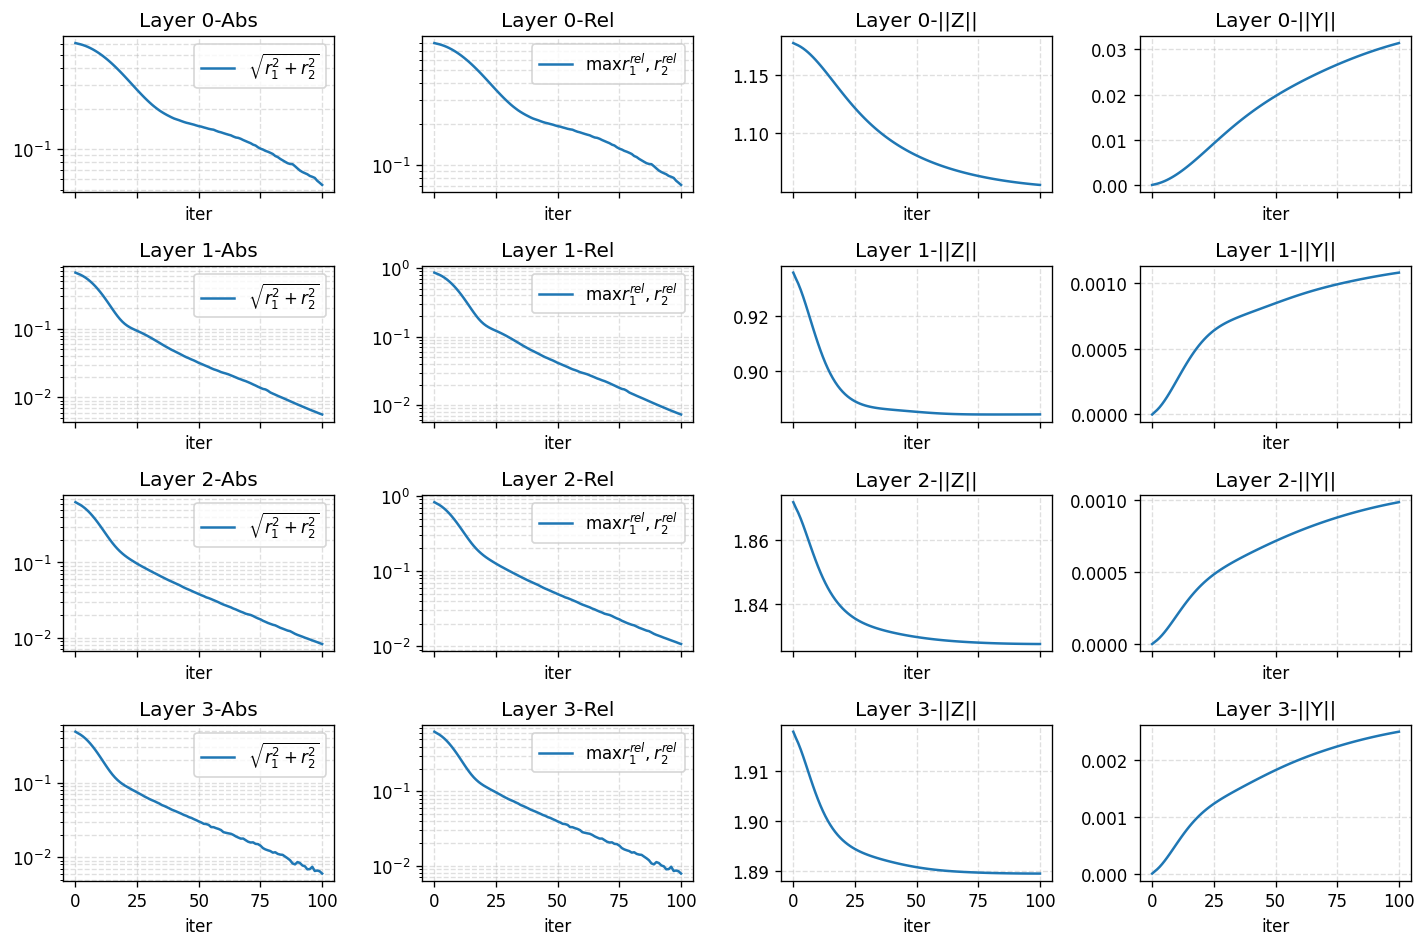

In [6]:
it = 50
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1
  layer    A1_norm    A2_norm   G2_norm   G1_norm    Y_norm
0     0  17.180927  15.719300  0.164158  0.073218  0.043625
1     1  10.558094  10.418432  0.020238  0.017111  0.003349
2     2   6.975651   7.015455  0.006214  0.004505  0.001475
3     3   7.407943   7.528679  0.045827  0.041890  0.004912


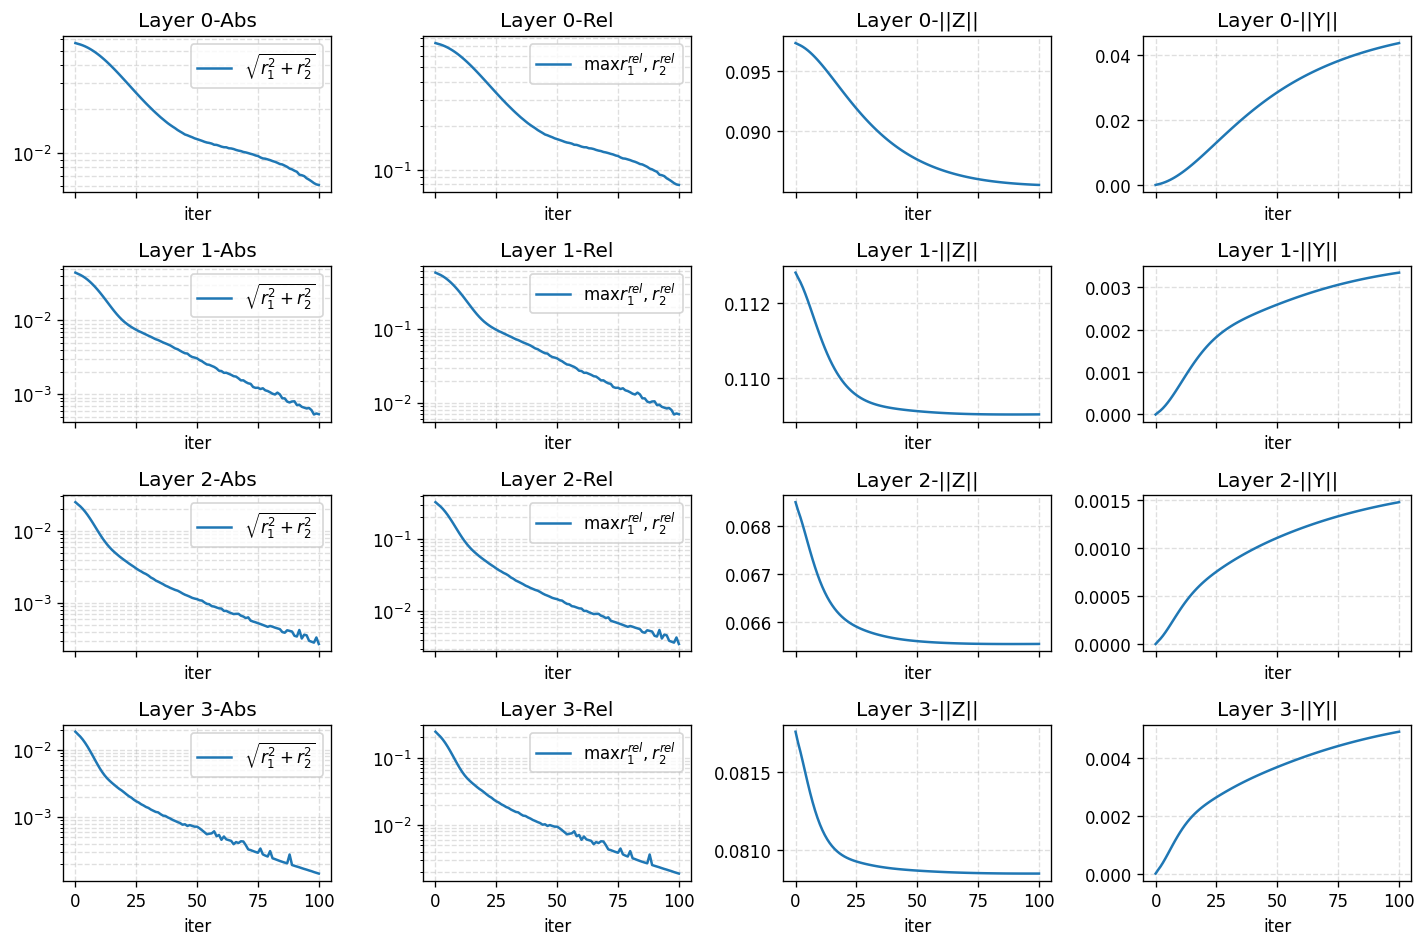

In [7]:
it = -1
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "A1_norm": layer_res["A1_norm"], "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"], "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)